# Figure 1 - marginal effects of extremes
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats

Data locations

In [2]:
loc_panel = "../Data/Panel/"
loc_regression = "../Data/RegressionResults/"
loc_shp = "../Data/Shapefile/"

#### Analysis/plotting

Read shapefile

In [3]:
shp = gp.read_file(loc_shp+"gadm36_1.shp")
shp = shp.rename(columns={"GID_1":"region"})

Choose extreme metric

In [4]:
extr = "tx5d"
bootstrap_type = "region"
nlag = 5 # if using distributed lag model

Read panel to get scalings

In [5]:
edd_type = "month"
panel = pd.read_csv(loc_panel+"extremes_growth_panel_"+edd_type+"edd_1979-2016.csv",index_col=0)
panel = panel.loc[panel.t!=0,:] # T being exactly zero is an error
scaling = 100*np.nanmean(panel.groupby("region").std()[extr].values)

Get coefficients

In [14]:
ts = np.arange(-5,35+1,1)
coefs_in = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_contemporaneous.csv",index_col=0)
coefs_main = coefs_in.coef_main.values
coefs_interact = coefs_in.coef_interact.values
    
nboot = len(coefs_main)
boot = np.arange(0,nboot,1)
me = np.zeros((nboot,len(ts)))
for n in np.arange(0,nboot,1):
    me[n,:] = scaling*(coefs_main[n] + coefs_interact[n]*ts)
me_mean = np.mean(me,axis=0)
me_lower = np.percentile(me,2.5,axis=0)
me_upper = np.percentile(me,97.5,axis=0)

Get estimation and overall sample

In [15]:
ts_estimation = np.unique(panel.loc[(~np.isnan(panel.growth.values)),"t"].values)
ts_all = np.unique(panel.loc[:,"t"].values)

Relative GDPpc in temperature bins

In [16]:
ts_bins = np.arange(-5,35+1,1)
relative_gpc = np.zeros(len(ts_bins))
gpc_mean = np.nanmean(np.exp(panel.lgdp_pc_usd.values))
for ts1 in ts_bins:
    ts2 = ts1+1
    mean_gpc = np.nanmean(np.exp(panel.loc[(panel.t>=ts1)&(panel.t<ts2),"lgdp_pc_usd"].values))
    relative_gpc[list(ts_bins).index(ts1)] = mean_gpc/gpc_mean - 1

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


Calculate marginal effects for each region

In [17]:
panel["gr_exists"] = [int(~np.isnan(x)) for x in panel.growth.values]
gr_n = panel.groupby("region").sum().loc[:,"gr_exists"].reset_index()
gr_n["in_sample"] = (gr_n.gr_exists>0).astype(int)

In [18]:
me_data = panel.groupby("region").mean().reset_index().loc[:,["lgdp_pc_usd","region","t"]]
me_data = me_data.loc[me_data.t!=0,:] # if its exactly zero, that indicates an error
coef_main_mean = np.nanmean(coefs_main)
coef_intr_mean = np.nanmean(coefs_interact)
me_data["ame_std"] = np.zeros(len(me_data.t.values))
for i in me_data.index.values:
    ts_i = me_data.loc[me_data.index==i,"t"].values[0]
    me_data.loc[me_data.index==i,"ame_std"] = scaling*(coef_main_mean + coef_intr_mean*ts_i)
shp_plot = pd.merge(shp,me_data,on="region",how="left")
shp_plot = pd.merge(shp_plot,gr_n,on="region",how="left")

In [19]:
coef_main_mean

0.008693450255390723

Plot!

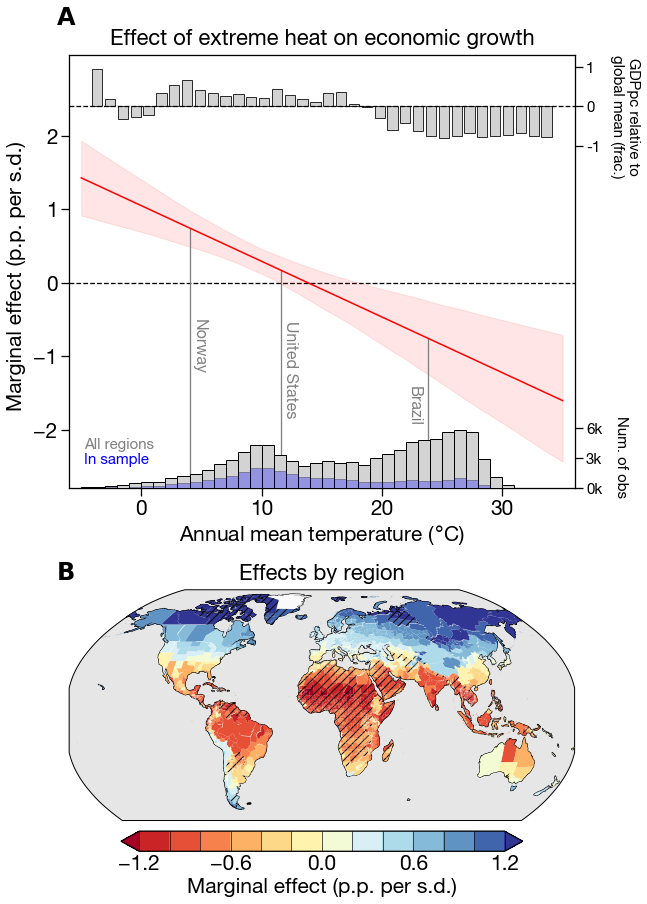

In [20]:
fig = plt.figure(figsize=(9,14))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.11,right=0.89,top=0.9,bottom=0.47,wspace=0.19,hspace=0.3)

ax = plt.subplot(gs1[0,0])

plt.plot(ts,me_mean,color="red",linewidth=1.5,zorder=3)
ax.fill_between(ts,me_lower,me_upper,
                   color="red",alpha=0.1,zorder=2)

plt.ylim([-2.8,3.1])
plt.xlim([-6,36])
plt.xticks([0,10,20,30])
plt.yticks([-2,-1,0,1,2])
plt.axhline(y=0,linewidth=1.3,color="black",
            linestyle="--",zorder=1)

plt.ylabel("Marginal effect (p.p. per s.d.)")
ax.yaxis.set_label_coords(-0.085,0.49)

tfs = 22
plt.xlabel("Annual mean temperature ($\degree$C)")
plt.title("Effect of extreme heat on economic growth",pad=10,fontsize=tfs)

## add vertical lines
cs = ["BRA","NOR","USA"]
nms = ["Brazil","Norway","United States"]
ymins = [-3,-3,-3]
ypos = [-1.9,-1.2,-1.8]
xoffset = [-1.8,0.2,0.2]
for j in [0,1,2]:
    ctry = cs[j]
    c_ts = np.nanmean(panel.loc[[ctry in x for x in panel.region.values],"t"])
    c_ame = (np.mean(coefs_main) + (np.mean(coefs_interact)*c_ts))*scaling
    plt.plot([c_ts,c_ts],[ymins[j],c_ame],
            linewidth=1.3,color="gray")
    plt.text(c_ts+xoffset[j],ypos[j],nms[j],rotation=270,
             color="gray",fontsize=16)

# for inset later
#plt.axhline(y=-3,color="gray",linestyle="-",linewidth=1.3)


## now map

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.11,right=0.89,top=0.38,bottom=0.13,wspace=0.19,hspace=0.3)

ax = plt.subplot(gs2[0,0],projection=ccrs.Robinson())

ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.98,0.98,0.98])
plt.setp(ax.spines.values(), linewidth=0.3)
plt.title("Effects by region",fontsize=tfs,pad=10)

# set colors
vmin = -1.2
vmax = 1.2
ncol = 13 # choose a number greater than
                  # the number of colors you actually want
bounds = np.linspace(vmin,vmax,ncol)
cmapname = 'RdYlBu'
cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
cm = colors.ListedColormap(cols[1:-1])
cm.set_over(cols[-1])
cm.set_under(cols[0]) #set_under(cols[0])
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
baseline_col = [0.99,0.99,0.99]


# add geometries
for i in shp_plot.region:
    geom = shp_plot.loc[shp_plot.region==i,"geometry"]
    val = shp_plot.loc[shp_plot.region==i,"ame_std"].values[0]
    col = cbar.to_rgba(val)
    in_smp = shp_plot.loc[shp_plot.region==i,"in_sample"].values[0]
    if ((in_smp==1) & (~np.isnan(val))):
        ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                     edgecolor="black",linewidth=0,zorder=10)
    elif ((in_smp==0) & (~np.isnan(val))):
        ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                     edgecolor="black",linewidth=0,
                              hatch="///",zorder=10)
    elif np.isnan(val):
        ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=[0.98,0.98,0.98],
                                     edgecolor="black",linewidth=0)



cbar_ax = fig.add_axes([0.19,0.11,0.62,0.02])
plt.setp(cbar_ax.spines.values(), linewidth=0.3)
tks = [-1.2,-0.6,0,0.6,1.2]
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                          drawedges=True,extend="both",ticks=tks)
cbar_ax.tick_params(direction="in",width=0.05)
cb.set_label(label="Marginal effect (p.p. per s.d.)")


## insert relative GDP per capita bar plot
bar_ax = fig.add_axes([0.11,0.81,0.78,0.08])
bar_ax.bar(x=ts_bins,height=relative_gpc,
          facecolor="lightgray",edgecolor="black",
          linewidth=0.8)
bar_ax.axhline(y=0,linewidth=1.3,color="black",
              linestyle="--")
bar_ax.spines["right"].set_visible(False)
bar_ax.spines["top"].set_visible(False)
bar_ax.spines["left"].set_visible(False)
bar_ax.spines["bottom"].set_visible(False)
#bar_ax.set_yticks([])
bar_ax.yaxis.set_label_position("right")
bar_ax.yaxis.tick_right()
bar_ax.set_yticks([-1,0,1])
bar_ax.set_yticklabels(labels=["-1","0","1"],
                       fontsize=15)
bar_ax.set_ylabel("GDPpc relative to"+"\n"+"global mean (frac.)",
                 fontsize=15,rotation=270,labelpad=38)
bar_ax.yaxis.set_label_coords(1.13,0.36)
bar_ax.set_xticks([])
bar_ax.patch.set_alpha(0)



## now insert histogram
hist_ax = fig.add_axes([0.11,0.47,0.78,0.1])

bns = np.arange(-5,35+1,1)
hist_ax.hist(ts_all,color="lightgray",
              linewidth=1,edgecolor="black",bins=bns,
             alpha=1,label="All regions")
hist_ax.hist(ts_estimation,color="blue",
              linewidth=1,edgecolor="black",bins=bns,
             alpha=0.3,label="In sample")

#hist_ax.legend(loc="center right",fontsize=15,
#              frameon=False,bbox_to_anchor=(0.8,0.6,0,0),
#              fancybox=False,handlelength=1)
plt.text(0.03,0.4,"All regions",color="gray",fontsize=15,
        transform=hist_ax.transAxes)
plt.text(0.03,0.25,"In sample",color="blue",fontsize=15,
        transform=hist_ax.transAxes)
hist_ax.spines["right"].set_visible(False)
hist_ax.spines["top"].set_visible(False)
hist_ax.set_xlim([-6,36])
hist_ax.set_ylim([0,10000])
hist_ax.spines["bottom"].set_visible(False)
hist_ax.spines["left"].set_visible(False)
hist_ax.set_xticks([])
hist_ax.yaxis.set_label_position("right")
hist_ax.yaxis.tick_right()
tks = [0,3000,6000]
hist_ax.set_yticks(tks)
hist_ax.set_yticklabels(labels=[str(int(x/1000))+"k" for x in tks],
                       fontsize=15)
hist_ax.set_ylabel("Num. of obs",rotation=270,
                  fontsize=15)
hist_ax.patch.set_alpha(0)
hist_ax.yaxis.set_label_coords(1.105,0.32)

plt.figtext(0.09,0.93,r'$\bf{A}$',fontsize=24)
plt.figtext(0.09,0.38,r'$\bf{B}$',fontsize=24)

plt.savefig("../Figures/Fig1.png",dpi=600)
plt.show()

In [21]:
np.nanmean(panel.loc[["BRA" in x for x in panel.region.values],"t"])

23.83226777521747

In [22]:
100*(coef_main_mean + coef_intr_mean*23.832)

-0.6282028392769352

In [23]:
np.nanmean(panel.loc[["NOR" in x for x in panel.region.values],"t"])

4.024583341728534

In [24]:
100*(coef_main_mean + coef_intr_mean*3.987)

0.6188111493632825